<a href="https://colab.research.google.com/github/thanhquan123hi1/Mini_test_student/blob/main/Mini_test_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Bước 1: Tải bộ dữ liệu train-test__

In [ ]:
!gdown --id '198gUVe3cD2S4f4o1WvQ1-ec8IzgLdujl'
!gdown --id '11A5-JqKM_186liurGZ_zd4nUjOB_Nl8s'
!unzip -q /content/train_imbalance.zip
!unzip -q /content/test_data.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=198gUVe3cD2S4f4o1WvQ1-ec8IzgLdujl
From (redirected): https://drive.google.com/uc?id=198gUVe3cD2S4f4o1WvQ1-ec8IzgLdujl&confirm=t&uuid=71508f5e-6f1c-4019-87e3-30da5ae2bd61
To: /content/train_imbalance.zip
100% 526M/526M [00:06<00:00, 75.9MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=11A5-JqKM_186liurGZ_zd4nUjOB_Nl8s
From (redirected): https://drive.google.com/uc?id=11A5-JqKM_186liurGZ_zd4nUjOB_Nl8s&confirm=t&uuid=a928ab88-36a1-4754-bb0c-9087af3b40aa
To: /content/test_da

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

# __Bước 2: Xây dựng class để đọc dữ liệu__

In [ ]:
import torch
import torchvision
from glob import glob
from torch.utils.data import Dataset
from PIL import Image
import os

CLASSES = ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']

class Data(Dataset):
  def __init__(self, transform=None, mode='train'):
    self.transform = transform
    self.mode = mode
    data = []

    if self.mode == 'train':
      class_dirs = glob('/content/train_imbalance/*')
      for c in class_dirs:
        label = os.path.basename(c)
        for path in glob(os.path.join(c, '*')):
          data.append((path, label))
    else:
      for path in glob('/content/test/*'):
            data.append((path, os.path.basename(path)))
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    if self.mode == 'train':
      img_path, c = self.data[idx]
    else:
      img_path, img_id = self.data[idx]

    img = Image.open(img_path).convert('RGB')

    if self.transform:
      img = self.transform(img)

    if self.mode == 'train':
      label = torch.tensor(CLASSES.index(c))
    else:
      label = img_id

    return img, label



In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])


batch_size = 4

trainset = Data(mode='train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = Data(mode='test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)





#### **Visualize**



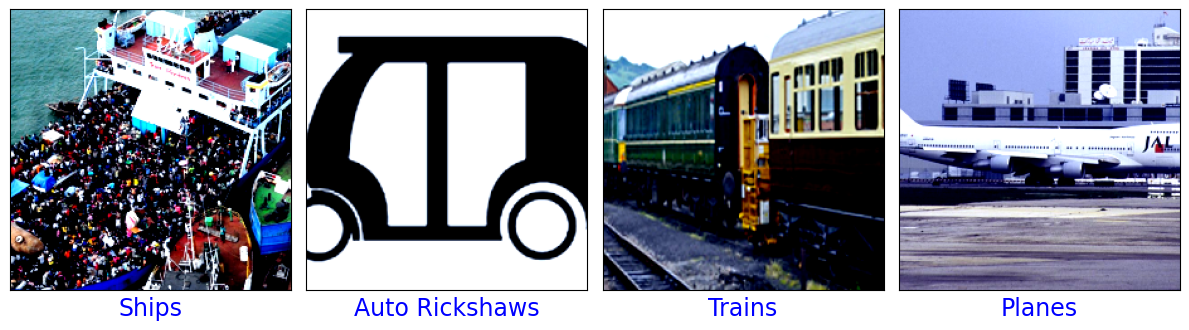

In [ ]:
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(trainloader)
images, labels = next(dataiter)

bs = images.shape[0]

plt.figure(figsize=(12, 4))

for i in range(bs):
    img = images[i] / 2 + 0.5
    npimg = img.numpy().transpose((1, 2, 0))

    plt.subplot(1, bs, i+1)
    plt.imshow(npimg)
    plt.xlabel(CLASSES[labels[i]], fontsize=17, color="Blue")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show();



# __Bước 3. Khởi tạo model__

In [ ]:
import torchvision.models as models
import torch.nn as nn

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(CLASSES))

model = model.to(device)

print(model)




ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# __Bước 4. Khởi tạo hàm Loss và Optimizer__

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)


# __Bước 5. Training Loop__

In [ ]:
num_epochs = 12
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}")



Epoch [1/12] - Loss: 0.6725 - Acc: 0.8035
Epoch [2/12] - Loss: 0.2975 - Acc: 0.9136
Epoch [3/12] - Loss: 0.2247 - Acc: 0.9408
Epoch [4/12] - Loss: 0.2302 - Acc: 0.9306
Epoch [5/12] - Loss: 0.1799 - Acc: 0.9486
Epoch [6/12] - Loss: 0.1533 - Acc: 0.9534
Epoch [7/12] - Loss: 0.1327 - Acc: 0.9597
Epoch [8/12] - Loss: 0.1474 - Acc: 0.9534
Epoch [9/12] - Loss: 0.1398 - Acc: 0.9631
Epoch [10/12] - Loss: 0.1364 - Acc: 0.9626
Epoch [11/12] - Loss: 0.1062 - Acc: 0.9704
Epoch [12/12] - Loss: 0.1058 - Acc: 0.9733


# **Bước 6. Biểu đồ**

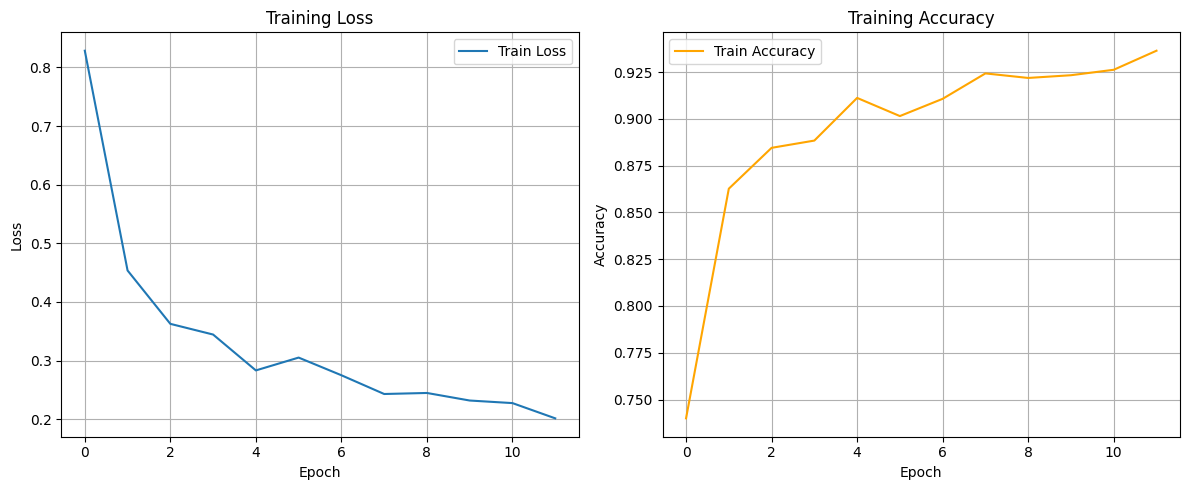

In [ ]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy", color="orange")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


# **Bước 7. Test**

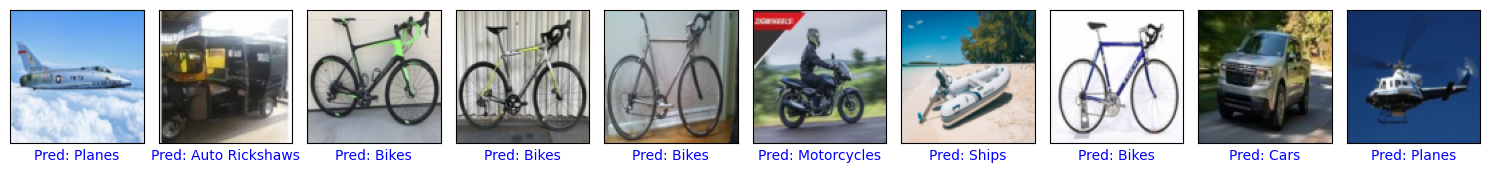

In [ ]:
import random

NUM_TEST = 10

chiso = random.sample(range(len(testset)), NUM_TEST)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(chiso):
    img, label = testset[idx]

    input_img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(input_img)
        _, pred = torch.max(out, 1)

    img_show = img / 2 + 0.5
    img_show = img_show.numpy().transpose((1, 2, 0))

    plt.subplot(1, NUM_TEST, i+1)
    plt.imshow(img_show)

    plt.xlabel(
        f"Pred: {CLASSES[pred]}", fontsize=10, color="blue"
    )

    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()



